In [133]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, plot_roc_curve, plot_confusion_matrix

from copy import copy

from time import time

import matplotlib.pyplot as plt
import category_encoders as ce

In [134]:
df = pd.read_csv('data/us census data.csv')
df = df.replace("?","Other")

In [135]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0,<=50K


In [136]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,48842.0,NaN,NaN,NaN,38.643585,13.71051,17.0,28.0,37.0,48.0,90.0
workclass,48842,7,Private,33906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,48842.0,NaN,NaN,NaN,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital-status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,48842,15,Prof-specialty,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,48842,6,Husband,19716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,48842,5,White,41762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,48842,2,Male,32650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours-per-week,48842.0,NaN,NaN,NaN,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [137]:
df['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [138]:
cat_df = copy(df)
cat_df.iloc[:,np.where(cat_df.dtypes == object)[0]] = cat_df.iloc[:,np.where(cat_df.dtypes == object)[0]].astype('category')

In [139]:
X = cat_df.iloc[:,:-1]
y = cat_df.iloc[:,-1]

ordinal_encoder = OrdinalEncoder(dtype=int)
label_encoder = LabelEncoder()

X_cat = X.iloc[:,np.where(X.dtypes == 'category')[0]]

X_enc_cat = ordinal_encoder.fit_transform(X_cat)
X_enc = copy(X)
X_enc.iloc[:,np.where(X.dtypes == 'category')[0]] = X_enc_cat
y_enc = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc,y_enc,test_size=0.2, random_state=1)

In [151]:
scoring = {'accuracy': make_scorer(accuracy_score)}

parameters = {
    "learning_rate": [0.05, 0.1, 0.2, 0.5],
    "max_depth":[3,4,5],
    "n_estimators": [100,200,300,400,500]
}

gbc_gs = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

gbc_gs.fit(X_train_enc, y_train_enc)
gbc_df = pd.DataFrame.from_dict(gbc_gs.cv_results_)

In [152]:
def get_best_params(cf_results_df):
    max_ind = cf_results_df['mean_test_accuracy'].argmax()
    thresh = cf_results_df['mean_test_accuracy'][max_ind] - cf_results_df['std_test_accuracy'][max_ind]
    min_ind = cf_results_df[cf_results_df['mean_test_accuracy'] >= thresh]['mean_fit_time'].argmin()
    return cf_results_df['params'][min_ind]

In [153]:
get_best_params(gbc_df)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 400}

In [36]:
start = time()
gbc = GradientBoostingClassifier(learning_rate=0.2,max_depth=3,n_estimators=100)
gbc.fit(X_train_enc,y_train_enc)
end = time()
print("Fitting time: ",end-start)

Fitting time:  4.172203063964844


In [37]:
def evaluate_model(model,X_test,y_test,verbose=True):
    y_pred = model.predict(X_test)
    label_encoder = LabelEncoder()
    y_test_f1, y_pred_f1 = label_encoder.fit_transform(y_test), label_encoder.fit_transform(y_pred)

    if verbose:
        plot_roc_curve(model,X_test,y_test)
        plot_confusion_matrix(model, X_test, y_test,normalize='true')

    return accuracy_score(y_test,y_pred), f1_score(y_test_f1,y_pred_f1)

(0.8691780120790255, 0.6991525423728813)

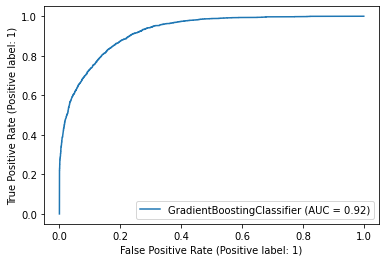

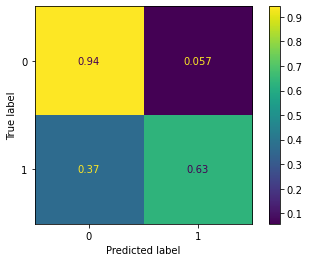

In [38]:
evaluate_model(gbc,X_test_enc,y_test_enc)

In [39]:
import catboost as cb

In [40]:
cat_features_indices = np.where(X_train.dtypes == 'category')[0]

In [232]:
cbc = cb.CatBoostClassifier(logging_level='Silent',eval_metric = 'Accuracy',cat_features=cat_features_indices)

scoring = {'accuracy': make_scorer(accuracy_score)}

parameters = {
    "max_depth":[2,3,4,5,6,7,8],
    "n_estimators": [100,200,300,400,500]
}
cbc_gs = GridSearchCV(cbc, parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

cbc_gs.fit(X_train, y_train)
cbc_df=pd.DataFrame.from_dict(cbc_gs.cv_results_)

KeyboardInterrupt: 

In [12]:
get_best_params(cbc_df)

NameError: name 'get_best_params' is not defined

In [41]:
train_dataset = cb.Pool(X_train,y_train,cat_features=cat_features_indices)
test_dataset = cb.Pool(X_test,y_test,cat_features=cat_features_indices)

start = time()
cbc = cb.CatBoostClassifier(logging_level='Silent',
                              cat_features=cat_features_indices,
                              depth=2,
                              iterations=500,
                              eval_metric='Accuracy'
                              )
cbc.fit(train_dataset,eval_set=test_dataset,plot=False)
end = time()
print("Fitting time: ",end-start)

Fitting time:  12.058682441711426


(0.8714300337803256, 0.7044705882352942)

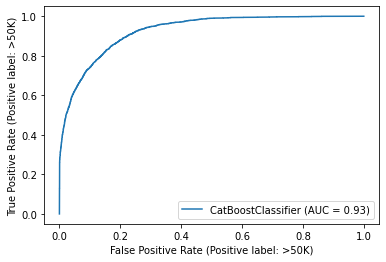

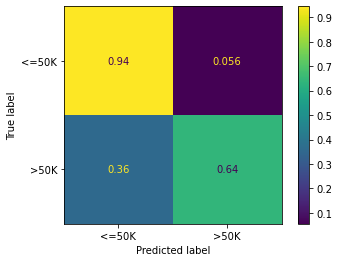

In [42]:
evaluate_model(cbc,X_test,y_test)

In [62]:
bin_df = copy(df)
bin_df.loc[bin_df['native-country'] != 'United-States', 'native-country'] = 'Other'

In [63]:
bin_df

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Other,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,36,United-States,0,<=50K
48838,64,Other,321403,HS-grad,Widowed,Other,Other-relative,Black,Male,40,United-States,0,<=50K
48839,38,Private,374983,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,0,<=50K
48840,44,Private,83891,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40,United-States,5455,<=50K


<BarContainer object of 2 artists>

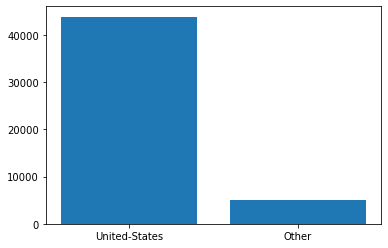

In [64]:
plt.bar(bin_df['native-country'].unique(),bin_df['native-country'].value_counts())

In [65]:
def encode_df(df, encode_method):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    y = LabelEncoder().fit_transform(y)

    encoder = encode_method(cols=X.iloc[:,np.where(X.dtypes == object)[0]].columns,return_df=True)
    X = encoder.fit_transform(X)

    return pd.concat((X,pd.Series(y).rename('income')),axis=1)

In [66]:
def compare_encoding(name_list,df_list,encode_list,iters=10):
    out = pd.DataFrame(columns=["name","mean_time","std-time","accuracy","f1_score"])
    for i, name in enumerate(name_list):
        times = []
        for j in range(iters):
            df = encode_df(df_list[i],encode_list[i])
            X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.2, random_state=1)
            start = time()
            gbc = GradientBoostingClassifier(learning_rate=0.2,max_depth=3,n_estimators=100)
            gbc.fit(X_train,y_train)
            end = time()
            times.append(end-start)

            acc, f1 = evaluate_model(gbc,X_test,y_test,verbose=False)

        mean_time = np.mean(times)
        std_time = np.std(times)
        out.loc[i] = [name,mean_time,std_time,acc,f1]

    return out

In [69]:
compare_encoding(["OneHot","Ordinal","BinaryOneHot","BinaryOrdinal"],
                 [df,df,bin_df,bin_df],
                 [ce.OneHotEncoder,ce.OrdinalEncoder,ce.OneHotEncoder,ce.OrdinalEncoder])

OneHot
OneHot
OneHot
OneHot
OneHot
OneHot
OneHot
OneHot
OneHot
OneHot
Ordinal
Ordinal
Ordinal
Ordinal
Ordinal
Ordinal
Ordinal
Ordinal
Ordinal
Ordinal
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOneHot
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal
BinaryOrdinal


,name,mean_time,std-time,accuracy,f1_score
0,OneHot,7.868613,0.422593,0.870304,0.697107
1,Ordinal,3.633770,0.018128,0.869178,0.693231
2,BinaryOneHot,5.985217,0.024035,0.870611,0.697897
3,BinaryOrdinal,3.602741,0.014863,0.869383,0.694005


In [57]:
import pickle

pickle.dump(gbc, open("./models/gbc.dat", "wb"))
pickle.dump(cbc, open("./models/cbc.dat", "wb"))

In [59]:
gbc = pickle.load(open("./models/gbc.dat", "rb"))

In [175]:
X_test

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital
391,27,Private,301302,Bachelors,Never-married,Craft-repair,Not-in-family,White,Male,50,United-States,0
1899,23,Private,119838,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,50,United-States,0
24506,21,Private,113106,Some-college,Never-married,Other-service,Own-child,White,Female,30,United-States,0
32816,21,Private,250939,Some-college,Never-married,Machine-op-inspct,Other-relative,White,Male,35,United-States,0
47892,32,Private,155151,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,55,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12999,31,Private,36302,Bachelors,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,50,United-States,0
43011,58,Local-gov,164970,HS-grad,Divorced,Adm-clerical,Not-in-family,Black,Male,40,United-States,0
34781,36,Private,398931,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,-1902
23537,25,Private,120238,Some-college,Married-civ-spouse,Sales,Husband,White,Male,43,United-States,2885


In [176]:
y_test

391      <=50K
1899     <=50K
24506    <=50K
32816    <=50K
47892    <=50K
         ...  
12999    <=50K
43011    <=50K
34781     >50K
23537    <=50K
23096    <=50K
Name: income, Length: 9769, dtype: category
Categories (2, object): ['<=50K', '>50K']